# load the data

In [1]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import pandas as pd

training_data = pd.read_csv("train.csv")

price_labels = ["low", "medium", "high"]

training_data["PriceCategory"], bins = pd.qcut(
    training_data["SalePrice"],
    q=3,
    labels=price_labels,
    retbins=True,
    duplicates="drop"
)

X = training_data.drop(columns=["Id", "SalePrice", "PriceCategory"])
y = training_data["PriceCategory"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


# preprocess the data

In [2]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# preprocess and convert to DataFrame for viewing
X_processed = preprocessor.fit_transform(X)
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)
X_processed_df = pd.DataFrame(X_processed.toarray(), columns=all_features)


# test various models and select the best

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel

# 1️⃣ Build a pipeline with a *placeholder* "selector" step
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance", VarianceThreshold(threshold=0.0)),
    ("selector", "passthrough"),
    ("classifier", MLPClassifier(
        hidden_layer_sizes=(64, 32),  # two hidden layers: 64 and 32 neurons
        activation="relu",
        solver="adam",
        max_iter=500,
        random_state=42
    ))
])

# 2️⃣ Tell GridSearchCV which options to try for "selector"
param_grid = {
    "selector": [
        "passthrough",
        SelectKBest(score_func=f_classif, k=100),
        SelectFromModel(
            LogisticRegression(
                penalty="l1",
                solver="saga",
                max_iter=10000
            )
        ),
    ],
}

# 3️⃣ Wrap the pipeline in GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,             # 5-fold cross-validation
    scoring="roc_auc_ovr",
    n_jobs=-1         # use all cores (optional, speeds things up)
)

# 4️⃣ Fit the whole thing
grid.fit(X_train, y_train)

# 5️⃣ Get the best pipeline (with the best selector choice)
best_pipeline = grid.best_estimator_

print("Best ROC AUC (OvR):", grid.best_score_)
print("Best selector:", grid.best_params_["selector"])

results = pd.DataFrame(grid.cv_results_)

# Show selector, mean score, std, and rank
summary = results[[
    "rank_test_score",
    "param_selector",
    "mean_test_score",
    "std_test_score"
]]

summary = summary.sort_values("rank_test_score")


Best ROC AUC (OvR): 0.9489582794188332
Best selector: SelectFromModel(estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                             solver='saga'))


# predict on the training test data

In [5]:
y_pred_cat = best_pipeline.predict(X_test)

# Take a look at predictions vs actual
training_results = pd.DataFrame({
    "expected": y_test.values,
    "predicted": y_pred_cat
})

training_results["correct"] = training_results["expected"] == training_results["predicted"]


# evaluate the model

              precision    recall  f1-score   support

        high       0.87      0.89      0.88        94
         low       0.86      0.93      0.89       110
      medium       0.78      0.68      0.73        88

    accuracy                           0.84       292
   macro avg       0.84      0.83      0.83       292
weighted avg       0.84      0.84      0.84       292



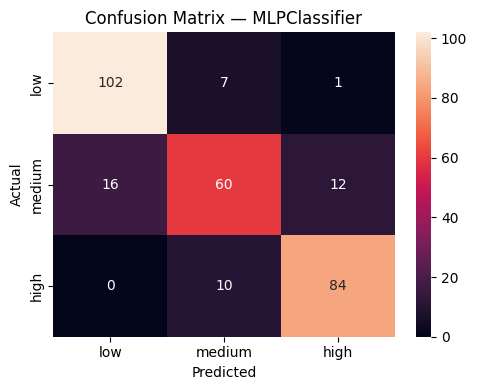

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test.values, y_pred_cat))

cm = confusion_matrix(y_test.values, y_pred_cat, labels=price_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=price_labels,
    yticklabels=price_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — MLPClassifier")
plt.tight_layout()
plt.show()

# run model against the test data file

In [7]:
test_data = pd.read_csv("test.csv")
predictions = best_pipeline.predict(test_data)

s = pd.Series(predictions)
counts = s.value_counts().rename("count")
percent = (counts / counts.sum() * 100).round(2).rename("percent")

summary = pd.concat([counts, percent], axis=1).reset_index()
summary = summary.rename(columns={"index": "PriceCategory"})

print(summary)


  PriceCategory  count  percent
0           low    524    35.92
1        medium    483    33.10
2          high    452    30.98
